# Importamos librerias

In [190]:
import numpy as np
import sympy as sp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

from importlib import reload
plt=reload(plt)

## Derivadas Parciales

In [191]:
def derivada_parcial(variable, funcion, valores=None):
    derivada = sp.diff(funcion, variable)

    if valores != None and type(valores) == dict:
        return derivada.subs(valores)
    
    elif valores != None and type(valores) == list:
        derivadas_evaluadas = []

        for i in valores:
            evaluar = sp.lambdify(variable, derivada)
            derivadas_evaluadas.append(evaluar(i))
        derivadas_evaluadas = np.array(derivadas_evaluadas)
        
        return derivadas_evaluadas

    elif valores != None and (type(valores) == int or type(valores) == float): return derivada.evalf(subs={variable: valores})

    else: return derivada

## Leer los archivos .txt

In [192]:
def fuerzas(nombre_archivo):
    f = open(f"{nombre_archivo}.txt",'r')
    lines = f.readlines()[4:-1]

    tiempo = [] #segundos
    posicion = [] #metros

    for line in lines:
        tiempo.append(float(line.split("\t")[0].replace(',', '.')))
        posicion.append(float(line.split("\t")[1].split("\n")[0].replace(',', '.')))

    tiempo = np.array(tiempo)
    posicion = np.array(posicion)

    return tiempo, posicion

## Chi Cuadrado

In [193]:
def chi_2(yi, fxi, sigma_yi, mediciones, parametros):
    p_libres = mediciones - parametros
    chi_2 = np.sum(((yi - fxi) / sigma_yi)**2)

    return chi_2, chi2.sf(chi_2, p_libres)

## Coeficiente de correlacion de Person

In [194]:
def coef_person(N, xi, yi):
    numerador_cp = ((N * (np.sum(xi * yi))) - (np.sum(xi) * np.sum(yi))) **2
    denominador_cp = ((N * np.sum(xi**2)) - (np.sum(xi))**2) * ((N * np.sum(yi**2)) - (np.sum(yi))**2)
    return np.sqrt(numerador_cp / denominador_cp)

# Desarrollo experimental
---

## <u> Análisis de datos sobre los resortes estáticos <u>

### Importamos los datos de los resortes y las masas que fueron colocadas

#### Masas Resorte


In [195]:
#Obtego los datos
datos = pd.read_excel('Mediciones resorte.xlsx')
masas_resorte_promedios = []
incerteza_mr = []

for i in range(0, 3):
    columna_masa = f'Masa {i}'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    masas_resorte_promedios.append(np.mean(pasadas))
    incerteza_mr.append(np.std(pasadas))

masas_resorte_promedios = np.array(masas_resorte_promedios)
incerteza_mr = np.array(incerteza_mr)

#Hago el pasaje de gramos a kg
masas_resorte_promedios = masas_resorte_promedios / 1000
incerteza_mr = incerteza_mr / 1000

#Paso de masa a pesos
pesos_resortes = []
gravedad = 9.807 #m/s^2

for i in masas_resorte_promedios:
    pesos_resortes.append(i*gravedad)

pesos_resortes = np.array(pesos_resortes)

Calculo el error de los pesos utilizados para el resorte

Desprecio el error de g:<br><br>
$\sigma_{peso}$ $\;$ $=$ $\;$ $\sqrt{g \sigma_{m_i}^2}$

In [196]:
incerteza_pesosr = np.sqrt(gravedad * (incerteza_mr)**2)

#### Resorte 1

In [197]:
datos = pd.read_excel('Mediciones resorte.xlsx')
longitud_resorte1 = []
incerteza_resorte1 = []

for i in range(0, 3):
    columna_masa = f'longitud{i}resorte1'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    longitud_resorte1.append(np.mean(pasadas))
    incerteza_resorte1.append(np.std(pasadas))

#Transformo las lista a arrays
longitud_resorte1 = np.array(longitud_resorte1)
incerteza_resorte1 = np.array(incerteza_resorte1)

#Hago el pasaje de cm a m
longitud_resorte1 = longitud_resorte1 / 100
incerteza_resorte1 = incerteza_resorte1 / 100

#### Resorte 2

In [198]:
datos = pd.read_excel('Mediciones resorte.xlsx')
longitud_resorte2 = []
incerteza_resorte2 = []

for i in range(0, 3):
    columna_masa = f'longitud{i}resorte2'
    pasadas = []
    for j in range(0, 5):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    longitud_resorte2.append(np.mean(pasadas))
    incerteza_resorte2.append(np.std(pasadas))

#Transformo las listas a arrays
longitud_resorte2 = np.array(longitud_resorte2)
incerteza_resorte2 = np.array(incerteza_resorte2)

#Hago el pasaje de cm a m
longitud_resorte2 = longitud_resorte2 / 100
incerteza_resorte2 = incerteza_resorte2 / 100

### <u>Cálculo de Constante Elástica<u>

A través de medir las longitudes de un resorte en un estado estático con una masa colgada, y utilizando la **segunda ley de newton** llegamos a la siguiente relación: <br>
$\;\;\;$ $\Rightarrow$ $F_e$ $\;$ $=$ $\;$ $Peso$ $\;$ $=$ $\;$ $-k(x-l_0)$

#### Visualizo los datos

Como la ecuación anterior presenta una relación lineal, para sacar mi valor de k y $l_0$ puedo utilizar cuadrados mínimos, para ello en el eje "y" debe estar aquel que posea mayor error o incerteza, por lo tanto proceso a calcularlo: <br><br>
$\sigma_{x}^{relativo}$ $=$ $\frac{\sigma_x}{|\bar{x}|}$

##### Calculo los errores relativos

Resorte 1

In [199]:
relativo_r1 = incerteza_resorte1 / longitud_resorte1
relativo_pr = incerteza_pesosr / pesos_resortes
print(f'Los errores relativos de las longitudes del resorte son: {relativo_r1} \nLos errores relativos de los pesos son: {relativo_pr} \nEl estiramiento va en el eje de las ordenadas')

Los errores relativos de las longitudes del resorte son: [0.00821976 0.00587453 0.0024446 ] 
Los errores relativos de los pesos son: [3.04587810e-04 6.24521135e-05 1.33305735e-04] 
El estiramiento va en el eje de las ordenadas


Resorte 2

In [200]:
relativo_r2 = incerteza_resorte2 / longitud_resorte2
relativo_pr = incerteza_pesosr / pesos_resortes
print(f'Los errores relativos de las longitudes del resorte son: {relativo_r1} \nLos errores relativos de los pesos son: {relativo_pr} \nEl estiramiento va en el eje de las ordenadas')

Los errores relativos de las longitudes del resorte son: [0.00821976 0.00587453 0.0024446 ] 
Los errores relativos de los pesos son: [3.04587810e-04 6.24521135e-05 1.33305735e-04] 
El estiramiento va en el eje de las ordenadas


Como el estiramiento posee mayor error que los pesos, pasamos a la siguiente ecuacion: <br><br>
$x(P) = $ $-\frac{1}{k} P$ + $l_0$<br><br>
Y con el ajuste obtengo los siguientes datos:
 * k = $\frac{1}{A}$, $\;\;$ A := pendiente<br><br>
 * $l_0$ = B, $\;\;$ B:= ordenada al origen


##### Resorte 1

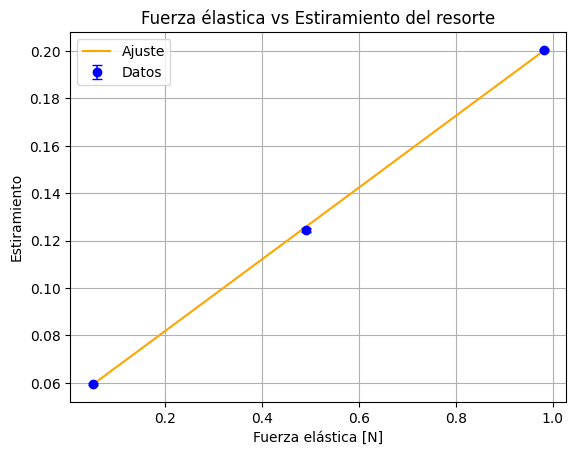

Los datos poseen una coorrelacion del: 0.9998829210965023
El chi cuadrado es de un valor de: (5.333194813799711, 0.06948826379708743)


In [201]:
#Aplico el ajuste
ajuste = CM_ponderados(pesos_resortes, longitud_resorte1, incerteza_resorte1)

#Realizo un plot
plt.figure()
plt.errorbar(pesos_resortes, longitud_resorte1, yerr=incerteza_resorte1, elinewidth=1.1, capsize=3.5, color='blue', fmt='o', label='Datos')
plt.plot(pesos_resortes, ajuste[0], color='orange', linestyle='-', label='Ajuste')

plt.title('Fuerza élastica vs Estiramiento del resorte')
plt.xlabel('Fuerza elástica [N]')
plt.ylabel('Estiramiento')

plt.legend(loc='upper left')
plt.grid()
plt.show()

#visualizo si se encuentran relacionados los datos:
print(f'Los datos poseen una coorrelacion del: {coef_person(len(pesos_resortes), pesos_resortes, longitud_resorte1)}')

#Visualizo bondad del ajuste
print(f'El chi cuadrado es de un valor de: {chi_2(longitud_resorte1, ajuste[0], incerteza_resorte1, 3, 1)}')

Obtengo los valores de k y $l_0$ del resorte 1

In [202]:
k_r1 = 1 / ajuste[1][0]
l0_r1 = ajuste[2][0]

Estimo sus incertezas:<br>
Como el k del resorte 1 depende A, aplico **Propagación de errores**:
 * $\sigma_k = \sqrt{\frac{1}{A^4} \sigma_A^2}$

In [203]:
incerteza_kr1 = np.sqrt((1 / ajuste[1][0]**2)**2 * (ajuste[1][1])**2)
incerteza_l0r1 = ajuste[2][1]

<u>Visualizo los valores de k y $l_0$ del resorte 1<u>

In [204]:
print(f'|El valor de k = {k_r1}, y su incerteza es = {incerteza_kr1}| y |El valor del l0 = {l0_r1}, y su incerteza es = {incerteza_l0r1}|')

|El valor de k = 6.608288044669324, y su incerteza es = 0.03250025076952993| y |El valor del l0 = 0.051617497584289344, y su incerteza es = 0.0004927062036069569|


##### Resorte 2

Realizo el mismo procedimiento que hice para el **resorte 1**

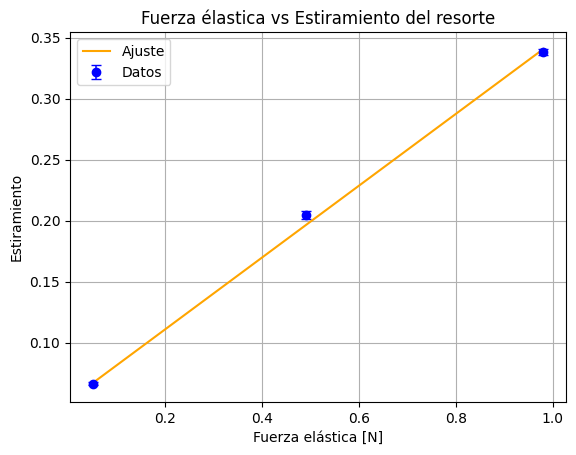

Los datos poseen una coorrelacion del: 0.9991292774126118
El chi cuadrado es de un valor de: (7.881145096629556, 0.019437082889874127)


In [205]:
#Aplico el ajuste
ajuste2 = CM_ponderados(pesos_resortes, longitud_resorte2, incerteza_resorte2)

#Realizo un plot
plt.figure()
plt.errorbar(pesos_resortes, longitud_resorte2, yerr=incerteza_resorte2, elinewidth=1.1, capsize=3.5,color='blue', fmt='o', label='Datos')
plt.plot(pesos_resortes, ajuste2[0], color='orange', linestyle='-', label='Ajuste')

plt.title('Fuerza élastica vs Estiramiento del resorte')
plt.xlabel('Fuerza elástica [N]')
plt.ylabel('Estiramiento')

plt.legend(loc='upper left')
plt.grid()
plt.show()

#visualizo si se encuentran relacionados los datos:
print(f'Los datos poseen una coorrelacion del: {coef_person(len(pesos_resortes), pesos_resortes, longitud_resorte2)}')

#Visualizo bondad del ajuste
print(f'El chi cuadrado es de un valor de: {chi_2(longitud_resorte2, ajuste2[0], incerteza_resorte2, 3, 1)}')

Obtengo los valores de k y $l_0$ del resorte 2

In [206]:
k_r2 = 1 / ajuste2[1][0]
l0_r2 = ajuste2[2][0]

Estimo sus incertezas:<br>
Como el k del resorte 2 depende A, aplico **Propagación de errores**:
 * $\sigma_k = \sqrt{\frac{1}{A^4} \sigma_A^2}$

In [207]:
incerteza_kr2 = np.sqrt((1 / ajuste2[1][0]**2)**2 * (ajuste2[1][1])**2)
incerteza_l0r2 = ajuste[2][1]

<u>Visualizo los valores de k y $l_0$ del resorte 2<u>

In [208]:
print(f'|El valor de k = {k_r1}, y su incerteza es = {incerteza_kr1}| y |El valor del l0 = {l0_r1}, y su incerteza es = {incerteza_l0r1}|')

|El valor de k = 6.608288044669324, y su incerteza es = 0.03250025076952993| y |El valor del l0 = 0.051617497584289344, y su incerteza es = 0.0004927062036069569|


---
## <u>Análisis de datos sobre mi sistema en movimiento<u>

### Importamos los pesos del carrito:

In [209]:
#Obtengo los datos
datos = pd.read_excel('Masa carrito.xlsx')
masas_carrito_promedios = []

for i in range(0, 6):
    columna_masa = f'Masa {i} carro'
    pasadas = []
    for j in range(0, 4):
        if datos[columna_masa][j] != 'NaN':
            pasadas.append(datos[columna_masa][j])
    masas_carrito_promedios.append(np.mean(pasadas))

masas_carrito_promedios = np.array(masas_carrito_promedios)

#Hago el pasaje de gramos a kg
masas_carrito_promedios = masas_carrito_promedios / 1000

#Paso de masa a pesos
pesos_carritos = []

for i in masas_carrito_promedios:
    pesos_carritos.append(i*gravedad)

pesos_carritos = np.array(pesos_carritos)

El sensor nos devuelve una señal del estilo:<br><br>
$x(t)=A(\alpha t + C)sin(\omega t+\phi)+\lambda$<br><br>
donde: $\;\;$ AC($\frac{\alpha}{c}$ t + 1)sin($\omega$ t + $\phi$) + $\lambda$, y si llamamos:
 * AC = $\gamma$
 * $\frac{\alpha}{c}$ = $\beta$<br>
$\rightarrow$ $x(t)=\gamma (\beta t + 1)sin(\omega t + \phi) + \lambda$

Defino esto como funcion de python:

In [210]:
def xteo(t, gamma, beta,w, phi, l): return gamma*(beta*t + 1)*np.sin(w*t + phi) + l

### Ajustamos y visualizamos los datos

#### Masa 0

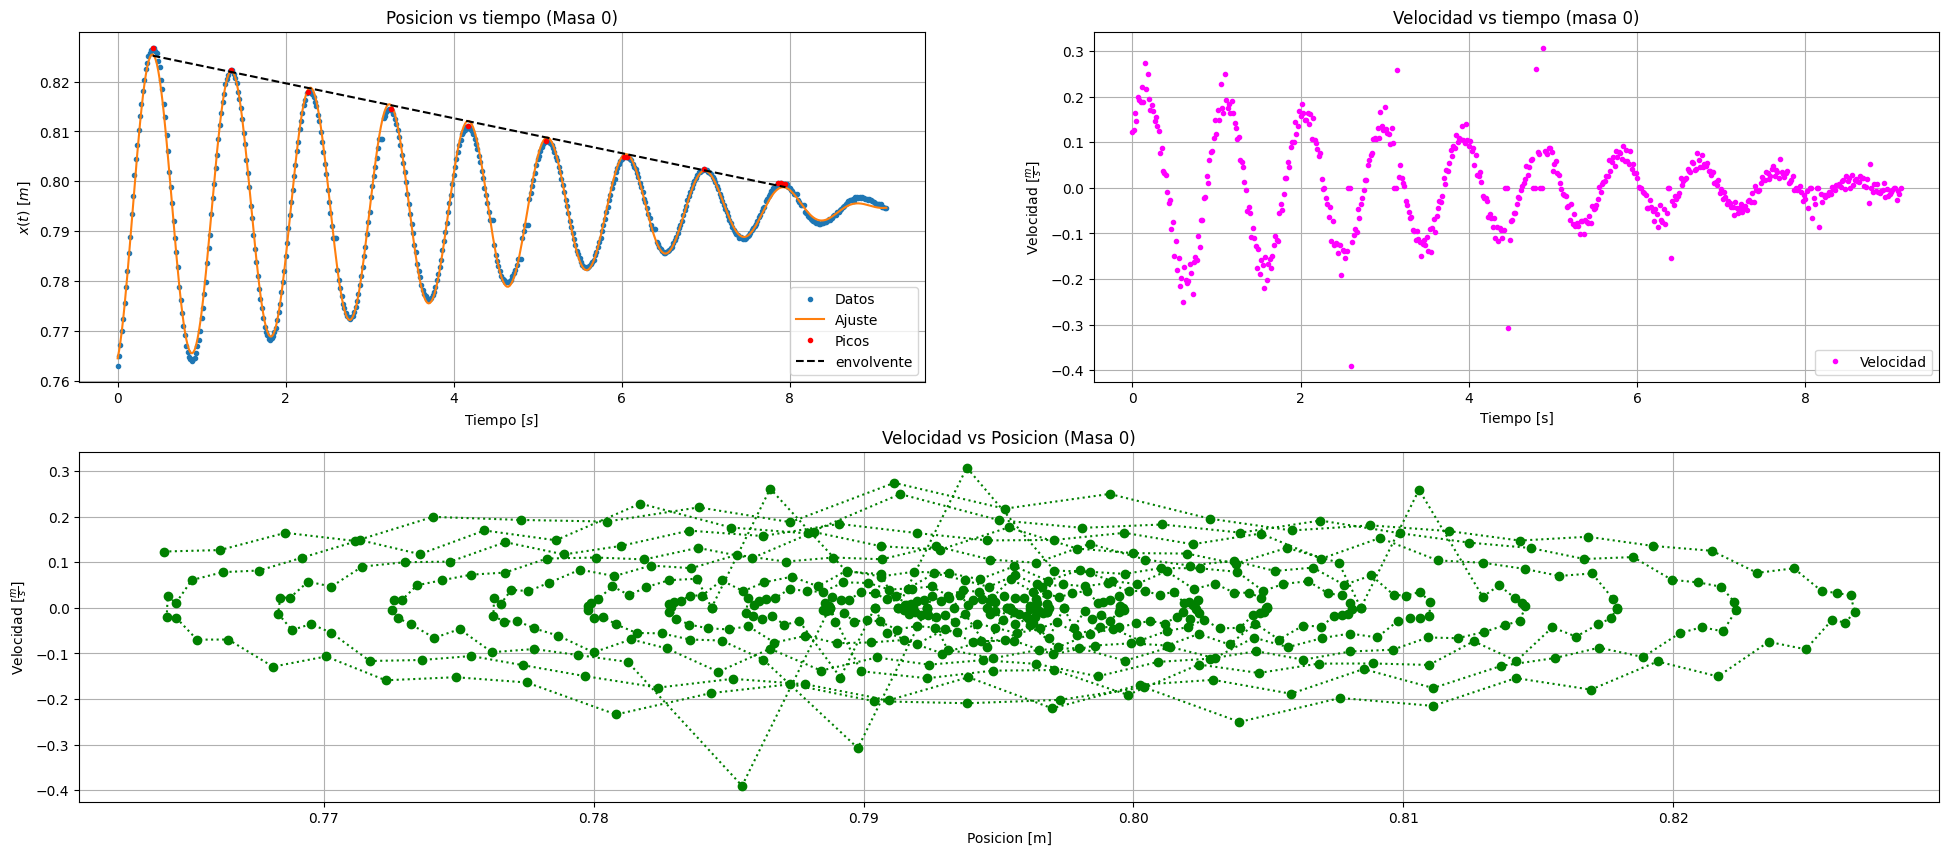

In [211]:
#Importamos los datos
posicion = fuerzas('m0')[1]
tiempo = fuerzas('m0')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 550
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_0 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_0 = popt[0]
beta_0 = popt[1]
w_0 = popt[2]
phi_0 = popt[3]
l_0 = popt[4]

#Derivo con respecto al tiempo
velocidades0 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x0_2 = (np.diff(posicion) / 2) + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_0, beta_0, w_0, phi_0, l_0), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 0)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades0, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 0)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x0_2, velocidades0, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 0)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

#### Masa 1

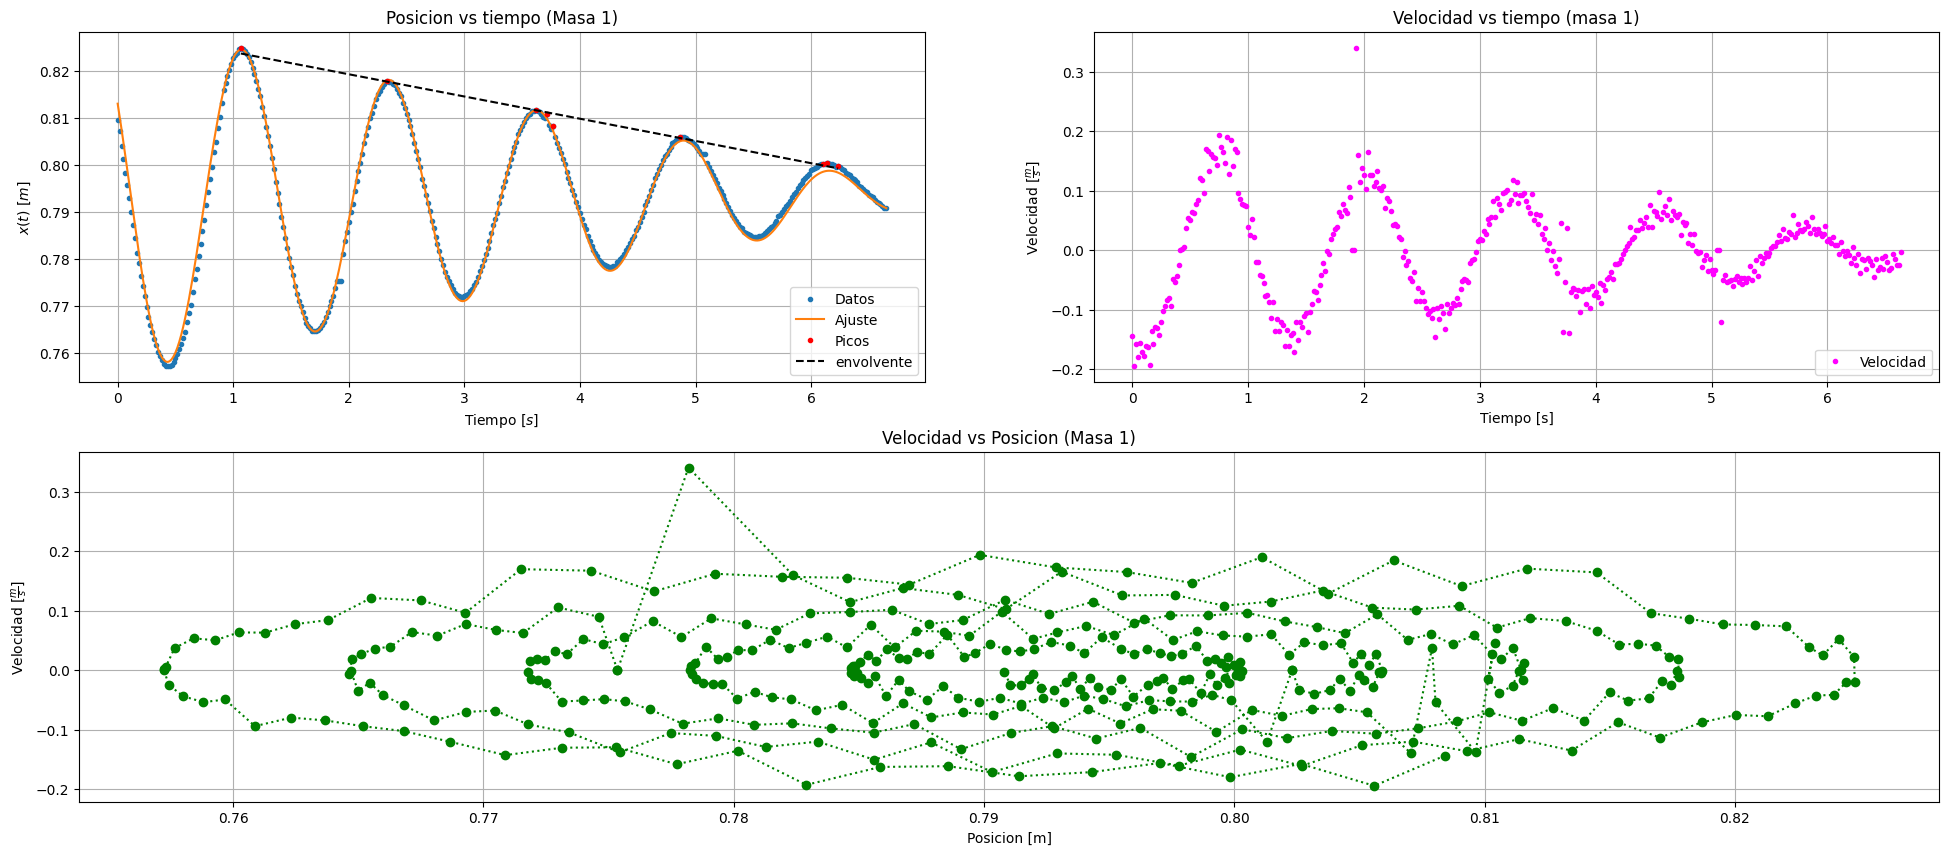

In [212]:
#Importamos los datos
posicion = fuerzas('m1')[1]
tiempo = fuerzas('m1')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 400
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_1 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_1 = popt[0]
beta_1 = popt[1]
w_1 = popt[2]
phi_1 = popt[3]
l_1 = popt[4]

#Derivo con respecto al tiempo
velocidades1 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x1_2 = np.diff(posicion) / 2 + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_1, beta_1, w_1, phi_1, l_1), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 1)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades1, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 1)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x1_2, velocidades1, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 1)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

#### Masa 2

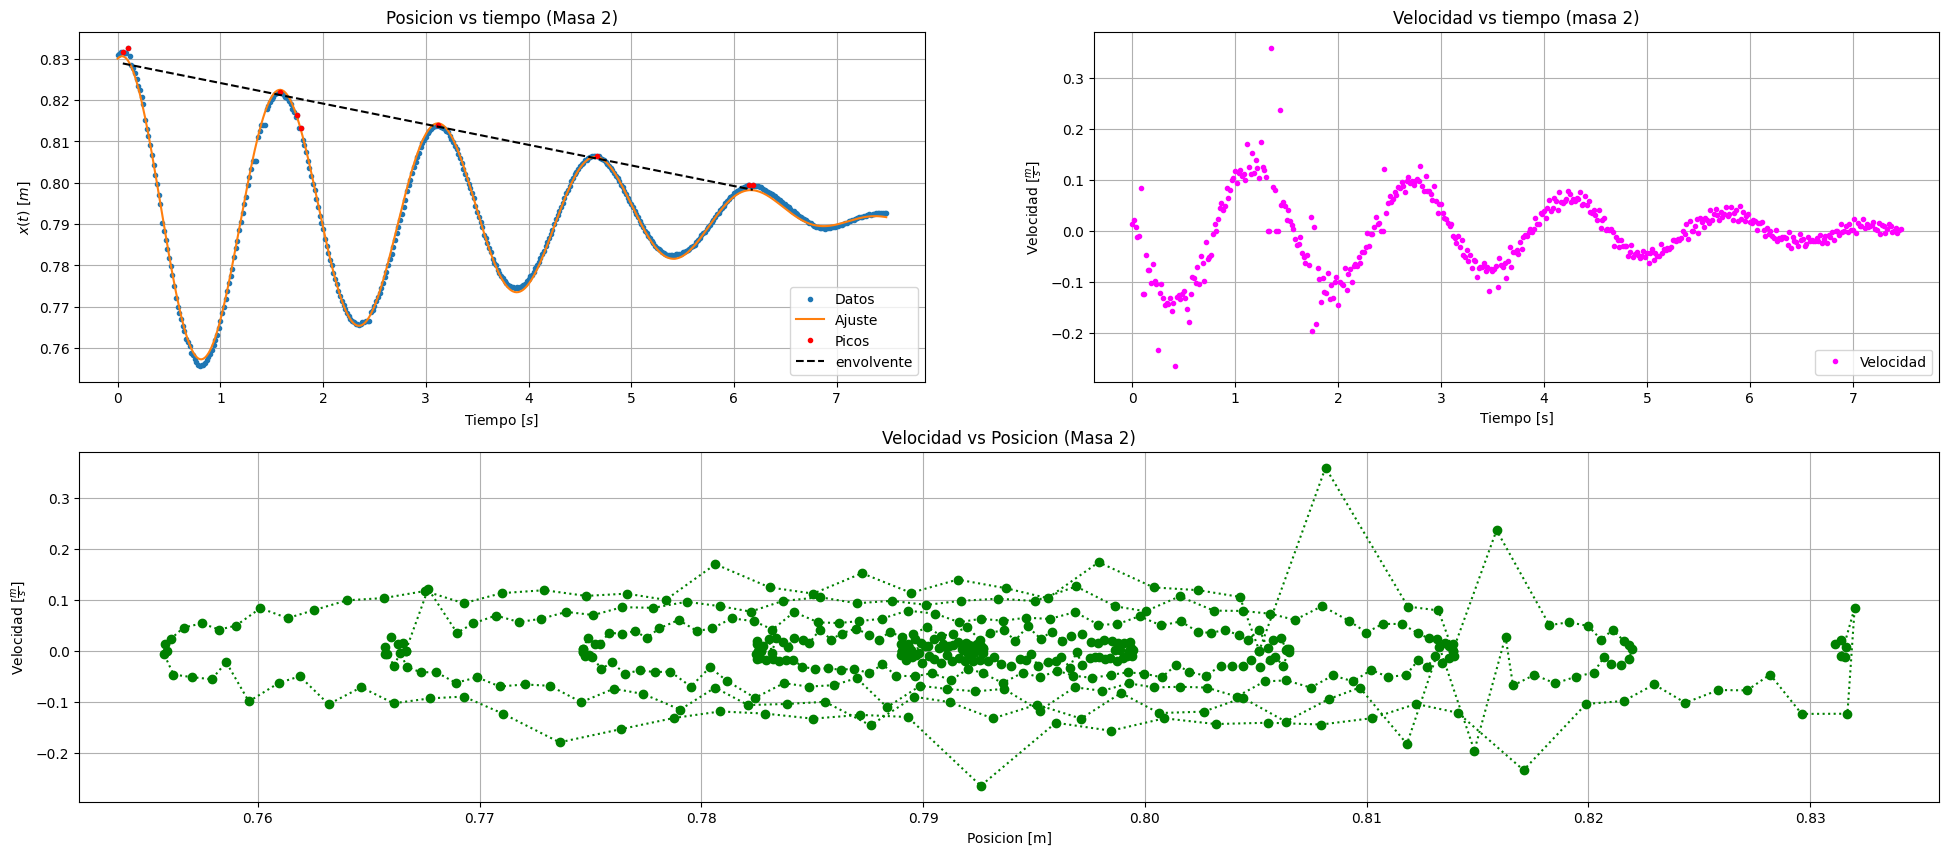

In [213]:
#Importamos los datos
posicion = fuerzas('m2')[1]
tiempo = fuerzas('m2')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 450
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_2 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_2 = popt[0]
beta_2 = popt[1]
w_2 = popt[2]
phi_2 = popt[3]
l_2 = popt[4]

#Derivo con respecto al tiempo
velocidades2 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x2_2 = np.diff(posicion) / 2 + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_2, beta_2, w_2, phi_2, l_2), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 2)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades2, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 2)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x2_2, velocidades2, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 2)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

#### Masa 3

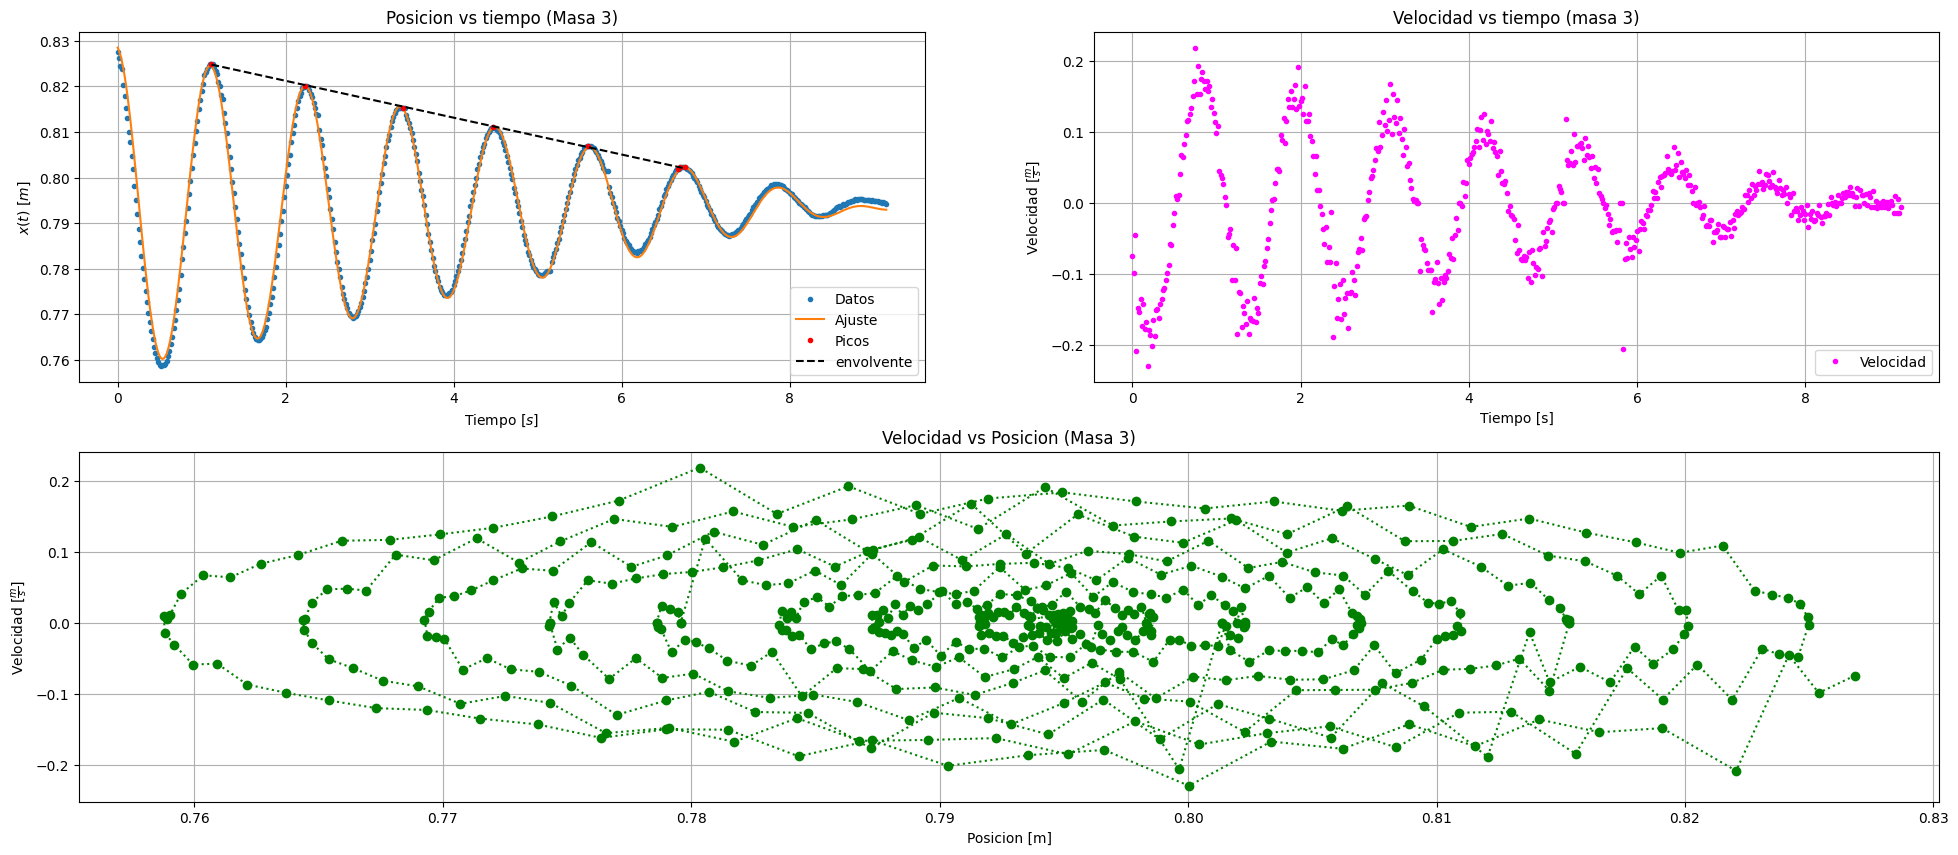

In [214]:
#Importamos los datos
posicion = fuerzas('m3')[1]
tiempo = fuerzas('m3')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 550
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_3 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_3 = popt[0]
beta_3 = popt[1]
w_3 = popt[2]
phi_3 = popt[3]
l_3 = popt[4]

#Derivo con respecto al tiempo
velocidades3 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x3_2 = np.diff(posicion) / 2 + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_3, beta_3, w_3, phi_3, l_3), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 3)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades3, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 3)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x3_2, velocidades3, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 3)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

#### Masa 4

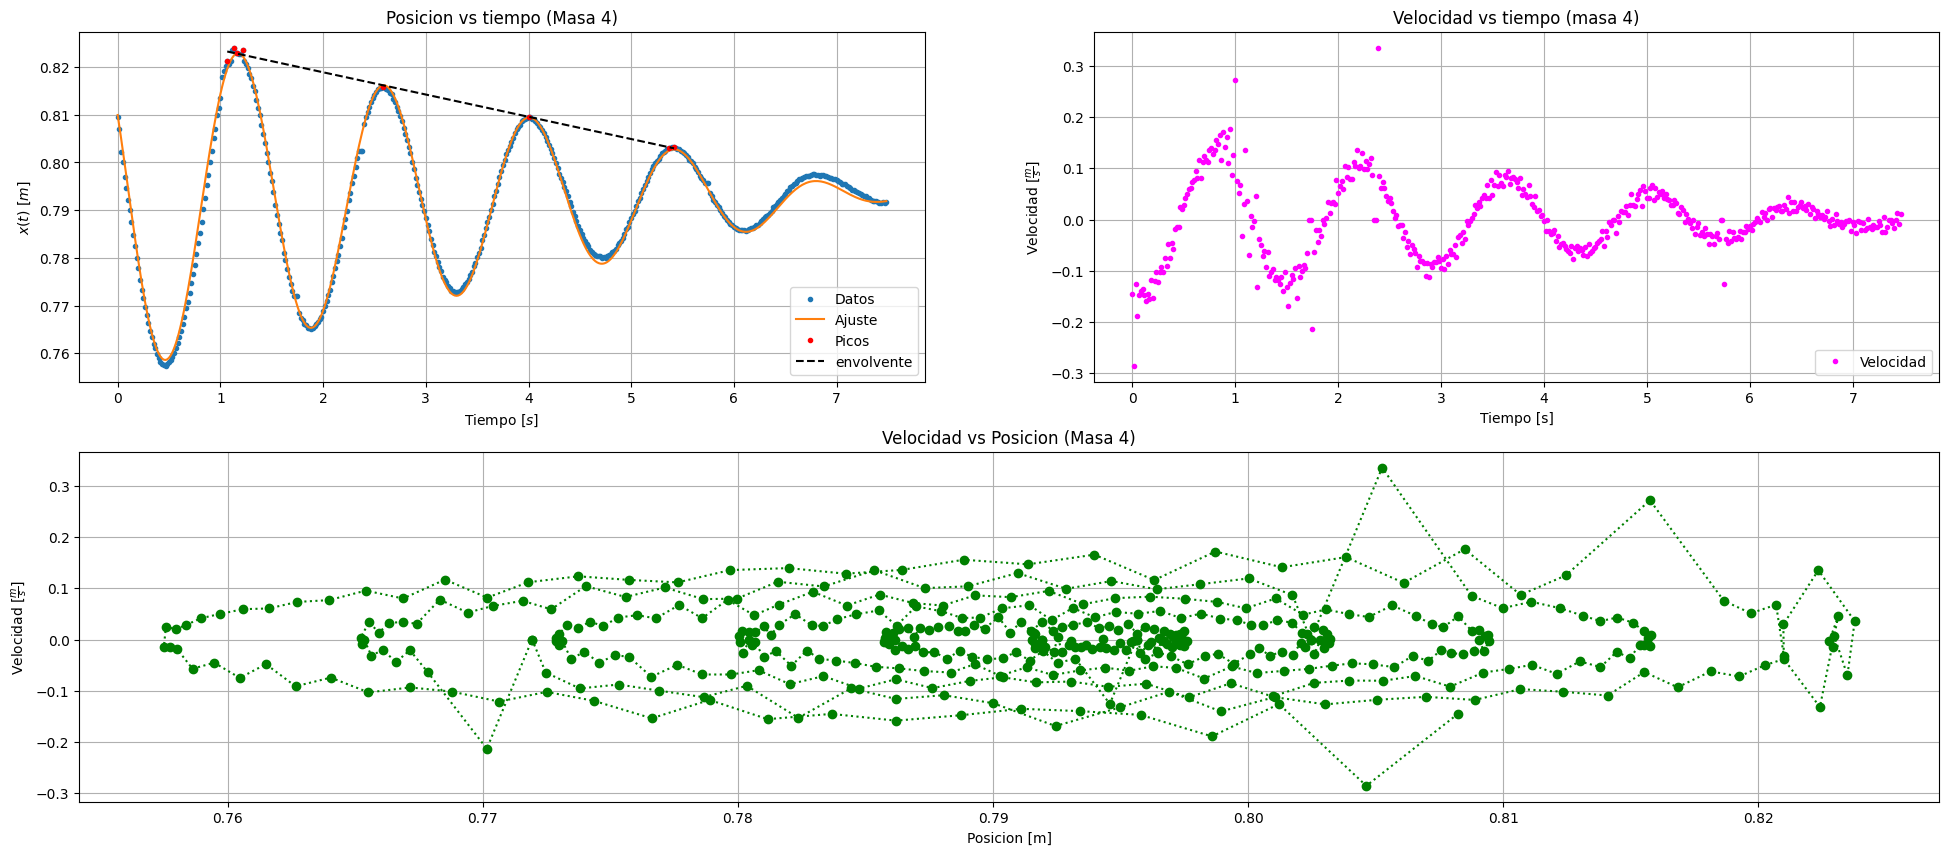

In [215]:
#Importamos los datos
posicion = fuerzas('m4')[1]
tiempo = fuerzas('m4')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 450
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_4 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_4 = popt[0]
beta_4 = popt[1]
w_4 = popt[2]
phi_4 = popt[3]
l_4 = popt[4]

#Derivo con respecto al tiempo
velocidades4 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x4_2 = np.diff(posicion) / 2 + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_4, beta_4, w_4, phi_4, l_4), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 4)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades4, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 4)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x4_2, velocidades4, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 4)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

#### Masa 5

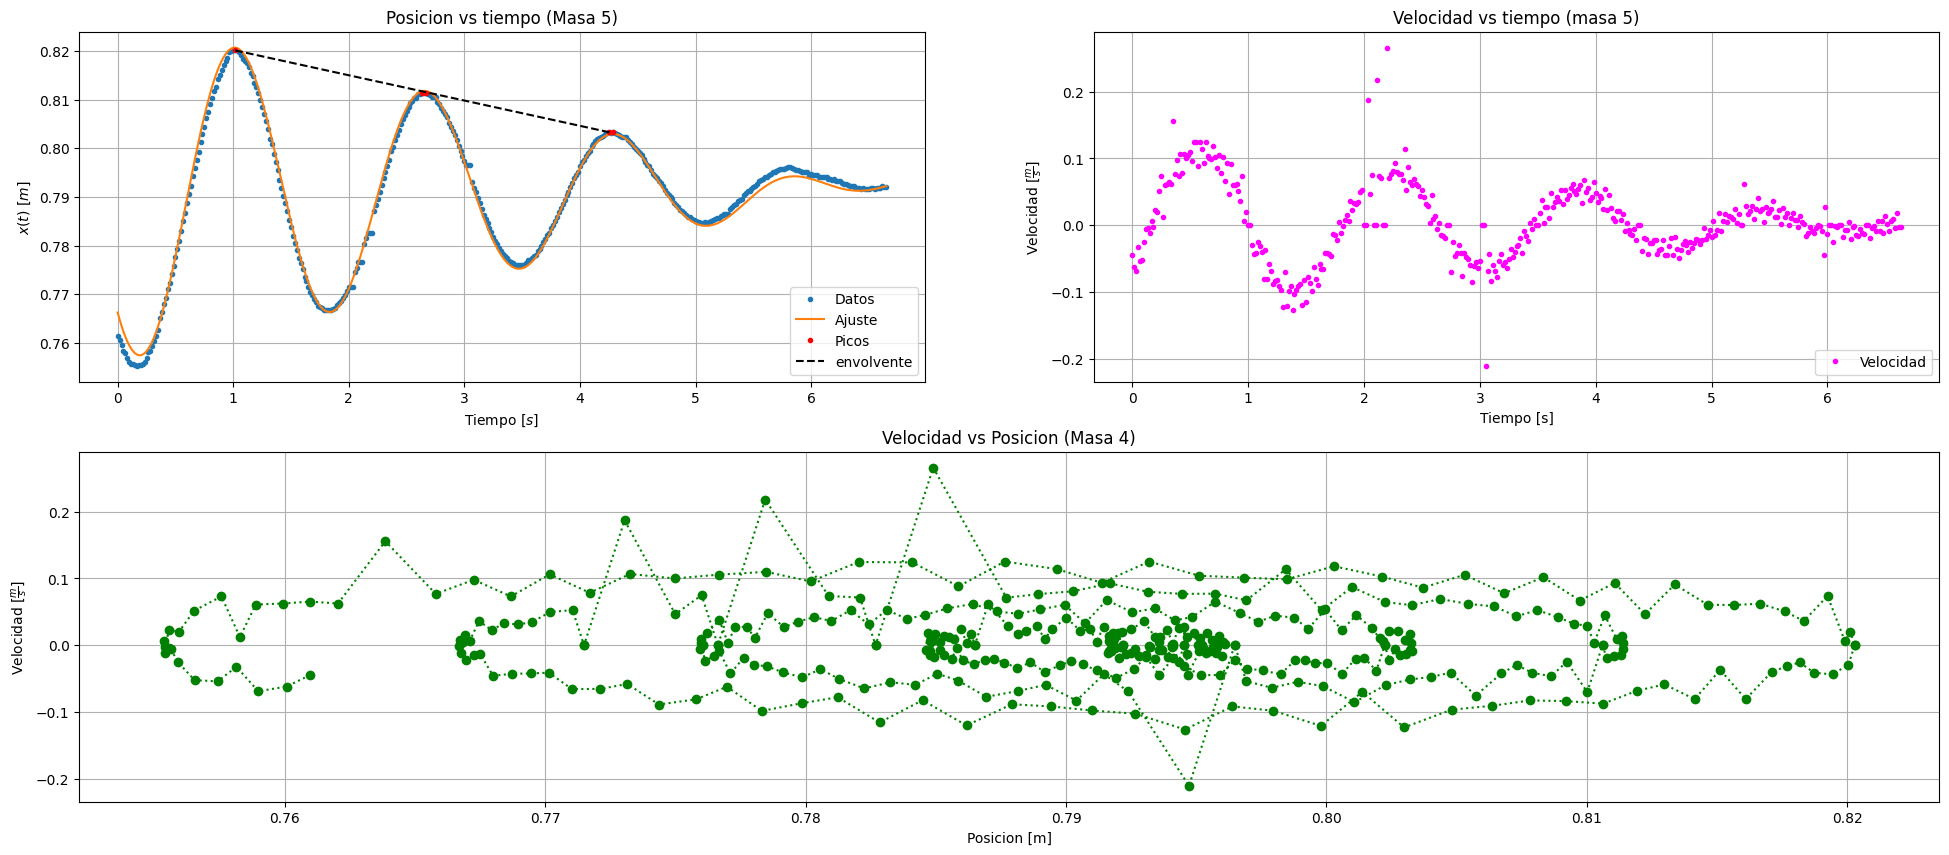

In [216]:
#Importamos los datos
posicion = fuerzas('m5')[1]
tiempo = fuerzas('m5')[0]

#Acortamos a los tiempos en los cuales la funcion decae a 0
N = 400
tiempo = tiempo[0:N]
posicion = posicion[0:N]

#Valores para el ajuste
gamma = 1 - 0.8
beta = 8
w = 4
phi = np.pi/2
l = 0.80

#Utilizamos Curvefit
popt, pcov = curve_fit(xteo, tiempo, posicion, p0=[gamma, beta, w, phi, l])
incertezas_5 = np.sqrt(np.diag(pcov))

#Obtenngo los datos de curvefit
gamma_5 = popt[0]
beta_5 = popt[1]
w_5 = popt[2]
phi_5 = popt[3]
l_5 = popt[4]

#Derivo con respecto al tiempo
velocidades5 = np.diff(posicion) / np.diff(tiempo)

#Busco las nuevas posiciones para comparar con el tiempo
x5_2 = np.diff(posicion) / 2 + posicion[:-1]

#Busco los picos
picos, _ = find_peaks(posicion, height=0.799)
p = np.polyfit(tiempo[picos], posicion[picos], 1)

#Realizo los plots para la comparacion
fig = plt.figure(figsize=(24,10))
spec = fig.add_gridspec(2,2)

#Realizamos un plot sobre posicion vs tiempo
axs00 = fig.add_subplot(spec[0,0])
axs00.plot(tiempo, posicion, '.', label='Datos')
axs00.plot(tiempo, xteo(tiempo, gamma_5, beta_5, w_5, phi_5, l_5), label='Ajuste')
axs00.plot(tiempo[picos], posicion[picos], color='red', linestyle='None', marker='.', label='Picos')
axs00.plot(tiempo[picos],np.polyval(p, tiempo[picos]), color='black', marker='None', linestyle='--', label='envolvente')
axs00.set(title=('Posicion vs tiempo (Masa 5)'),ylabel=(r'$x(t)$ $[m]$'), xlabel=(r'Tiempo [$s$]'))
axs00.legend(loc='lower right')
axs00.grid()

#Realizamos un plot sobre velocidad vs tiempo
axs01 = fig.add_subplot(spec[0,1])
axs01.plot(tiempo[:-1], velocidades5, color='magenta', marker='.', linestyle='None', label='Velocidad')
axs01.set(title=('Velocidad vs tiempo (masa 5)'), xlabel=('Tiempo [s]'), ylabel=(r'Velocidad $[\frac{m}{s}]$'))
axs01.legend(loc='lower right')
axs01.grid()

#Realizo un plot de posicion vs tiempo
axs1010 = fig.add_subplot(spec[1,:])
axs1010.plot(x5_2, velocidades5, color = 'green', marker='o', linestyle=':')
axs1010.set(title='Velocidad vs Posicion (Masa 4)', ylabel=r'Velocidad $[\frac{m}{s}]$', xlabel='Posicion [m]')
axs1010.grid()

plt.show()

### Plot sobre comparativas

#### $\omega$ vs masa

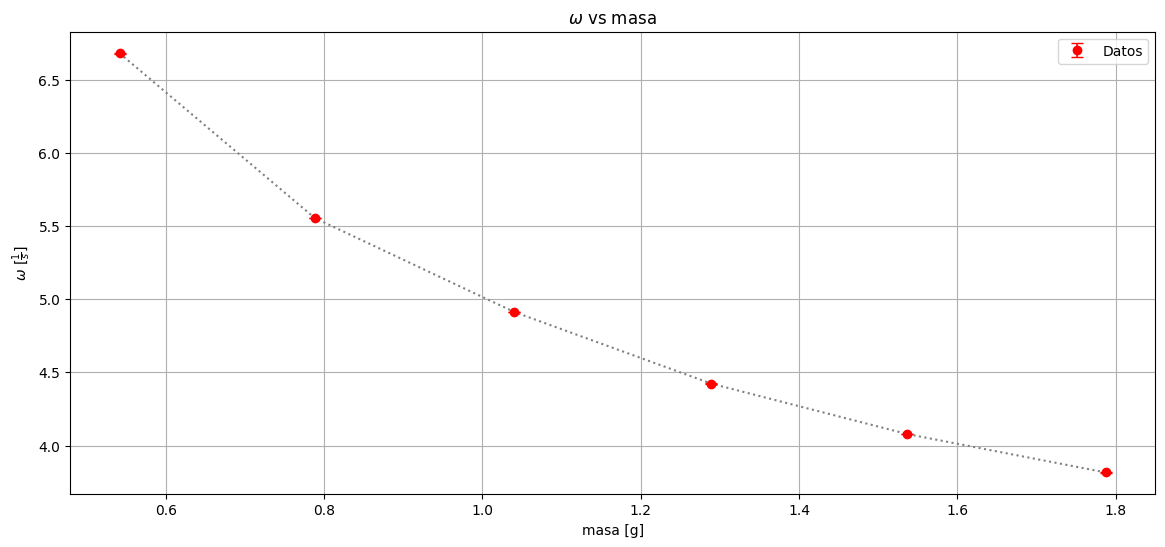

In [217]:
#Agrupo todas las frecuencias en una lista
w_total = np.array([w_0,w_1,w_2,w_3,w_4,w_5])#1/s
incertezas_w = np.array([incertezas_0[2], incertezas_1[2], incertezas_2[2], incertezas_3[2], incertezas_4[2], incertezas_5[2]])

#Realizo un plot w vs masa
plt.figure(figsize=(14,6))
plt.plot(sorted(masas_carrito_promedios), sorted(w_total, reverse=True),color='gray', marker='None', linestyle=':')
plt.errorbar(sorted(masas_carrito_promedios), sorted(w_total, reverse=True), yerr=sorted(incertezas_w, reverse=True), color='red', fmt='o', capsize=4, elinewidth=1.2,linestyle='None', label='Datos')

plt.title(r'$\omega$ vs masa')
plt.xlabel('masa [g]')
plt.ylabel(r'$\omega$ $[\frac{1}{s}]$')

plt.legend(loc='upper right')
plt.grid()
plt.show()

#### Rozamiento vs masas

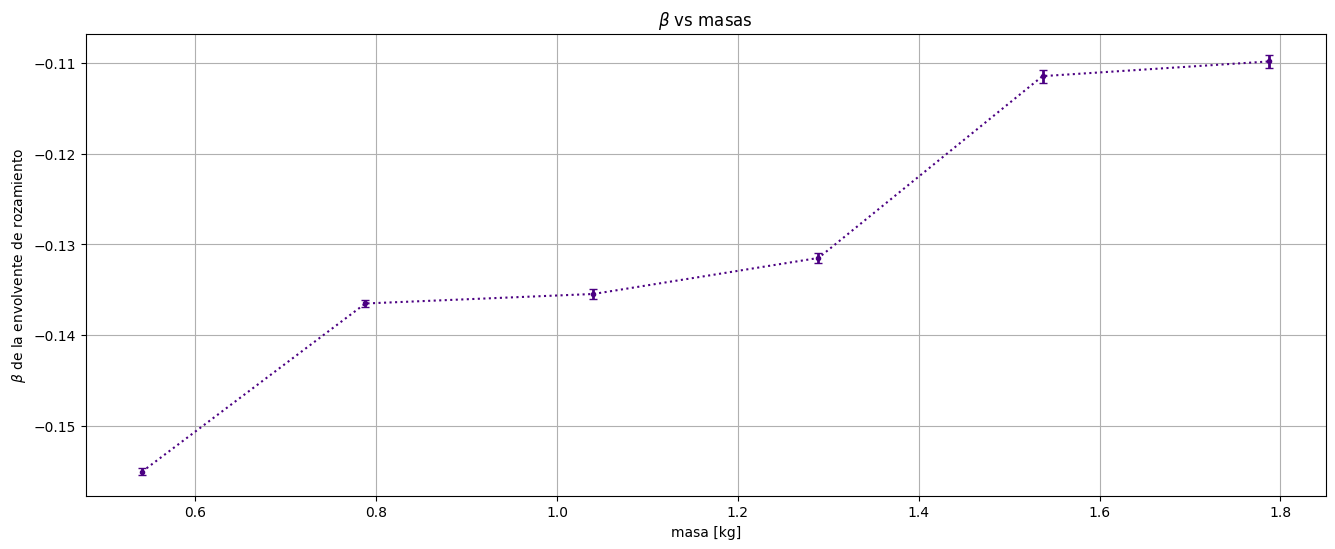

In [218]:
#Junto todas los betas en una lista junto a su incerteza
betas = np.array([beta_0, beta_1, beta_2, beta_3, beta_4, beta_5])
incertezas_betas = np.array([incertezas_0[1], incertezas_1[1], incertezas_2[1], incertezas_3[1], incertezas_4[1], incertezas_5[1]])

#Realizo plot comparativo
plt.figure(figsize=(16,6))
plt.errorbar(sorted(masas_carrito_promedios), sorted(betas), yerr=sorted(incertezas_betas), fmt='.', elinewidth=2, capsize=3,color='indigo', linestyle=':')

plt.title(r'$\beta$ vs masas')
plt.xlabel('masa [kg]')
plt.ylabel(r'$\beta$ de la envolvente de rozamiento')

plt.grid()
plt.show()